In [189]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, train_test_split, cross_val_predict, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import ttest_rel
import statsmodels.api as sm
import seaborn as sns



from utils import *

%load_ext autoreload
%autoreload 2
sns.set_context("talk")
condition = 'hf'


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Outline

## Load in
- Load in the three datasets (race1, race2, base)


In [55]:
DM_PATH = Path("/Users/jessbreda/Desktop/github/ca-sdoh/code/jess/design_matrices")
### READ IN
y = pd.read_csv(DM_PATH / f"{condition}_y.csv", index_col=False)
y = y.squeeze()

X_race_1 = pd.read_csv(DM_PATH / f"{condition}_X_race1.csv")
X_race_2 = pd.read_csv(DM_PATH / f"{condition}_X_race2.csv")
X_base = pd.read_csv(DM_PATH / f"{condition}_X_base.csv")

create standardized versions of each with added constant


In [56]:
# Standardized with mean 0, std 1
X_race_1_s = process_features(
    X_race_1,
    numeric_cols=X_race_1.columns,
)
X_race_2_s = process_features(
    X_race_2,
    numeric_cols=X_race_2.columns,
)
X_base_s = process_features(
    X_base,
    numeric_cols=X_base.columns,
)

In [22]:
# sns.pairplot(X_race_1_s, corner=True)

In [23]:
# sns.pairplot(X_race_2_s, corner=True)

In [24]:
# sns.pairplot(X_base_s, corner=True)

In [57]:
X_race_1_s = sm.add_constant(X_race_1_s)
X_race_2_s = sm.add_constant(X_race_2_s)
X_base_s = sm.add_constant(X_base_s)

In [58]:
assert len(X_race_1_s) == len(y) == len(X_race_2_s) == len(X_base_s), "lengths off!"
assert (
    X_race_2_s.shape[1] > X_race_1_s.shape[1] > X_base_s.shape[1]
), "columns incorrect!"
assert "readmission_rate" not in X_race_2_s.columns, "contains rr!!!"


## Linear Model
### Fit w/ CV
- run k_fold cross validation for 1, 2, base with same split for each fold
    - save out MSE, R^2 for each fold into a dataframe that also contains condition name, model type and model name



In [81]:
k = 10  # Number of folds

# Step 3: Perform k-fold cross-validation
kf = KFold(n_splits=k, shuffle=True, random_state=86)

# Initialize lists to store the RMSE and adjusted R-squared values for each model
lm_results = []

for i, (train_index, test_index) in enumerate(kf.split(X_base_s)):
    # Split the data into training and validation sets for the three models
    # with different feature sets, but same y
    X_train_base, X_test_base = (
        X_base_s.iloc[train_index],
        X_base_s.iloc[test_index],
    )
    X_train_race_1, X_test_race_1 = (
        X_race_1_s.iloc[train_index],
        X_race_1_s.iloc[test_index],
    )
    X_train_race_2, X_test_race_2 = (
        X_race_2_s.iloc[train_index],
        X_race_2_s.iloc[test_index],
    )

    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    ## BASE
    # Train and evaluate
    lm_model = sm.OLS(y_train, X_train_base).fit()
    y_pred = lm_model.predict(X_test_base)

    # Store the results for the base model
    result_dict = {
        "condition": "hf",
        "model_name": "Base",
        "model_type": "LM",
        "fold": i,
        "r2": lm_model.rsquared_adj,
        "mse": mean_squared_error(y_test, y_pred),
    }
    lm_results.append(result_dict)

    ## RACE 1
    # Train and evaluate
    lm_model = sm.OLS(y_train, X_train_race_1).fit()
    y_pred = lm_model.predict(X_test_race_1)

    # Store the results for the base model
    result_dict = {
        "condition": "hf",
        "model_name": "Base + Race 1",
        "model_type": "LM",
        "fold": i,
        "r2": lm_model.rsquared_adj,
        "mse": mean_squared_error(y_test, y_pred),
    }
    lm_results.append(result_dict)

    ## RACE 2
    # Train and evaluate
    lm_model = sm.OLS(y_train, X_train_race_2).fit()
    y_pred = lm_model.predict(X_test_race_2)

    # Store the results for the base model
    result_dict = {
        "condition": "hf",
        "model_name": "Base + Race 2",
        "model_type": "LM",
        "fold": i,
        "r2": lm_model.rsquared_adj,
        "mse": mean_squared_error(y_test, y_pred),
    }
    lm_results.append(result_dict)

lm_results = pd.DataFrame(lm_results)
lm_results["rmse"] = np.sqrt(lm_results["mse"])


### Eval
- plot performance of each model (RMSE + R^2) for each fold

In [183]:
lmpal = sns.color_palette("rocket", 4)
lmpal = lmpal.as_hex()

['#4c1d4b', '#a11a5b', '#e83f3f', '#f69c73']

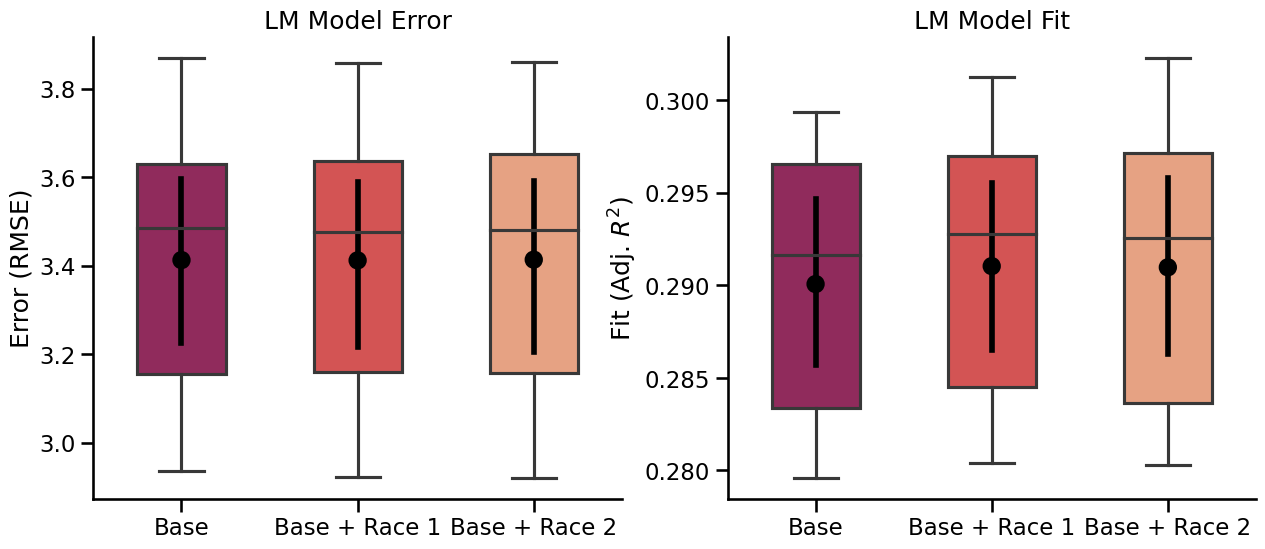

In [194]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
sns.despine()

plot_single_model_results(lm_results, ax, palette=lmpal[1:])


### Feature analysis
- run a full fit for each model and plot coefficients


In [142]:
lm_base = sm.OLS(y, X_base_s)
lm_base = lm_base.fit()

lm_race_1 = sm.OLS(y, X_race_1_s)
lm_race_1 = lm_race_1.fit()

lm_race_2 = sm.OLS(y, X_race_2_s)
lm_race_2 = lm_race_2.fit()

print(f"base model r^2 : {np.round(lm_base.rsquared_adj, 4)}")
print(f"race 1 model r^2 : {np.round(lm_race_1.rsquared_adj, 4)}")
print(f"race 2 model r^2 : {np.round(lm_race_2.rsquared_adj, 4)}")

base model r^2 : 0.2897
race 1 model r^2 : 0.2906
race 2 model r^2 : 0.2905


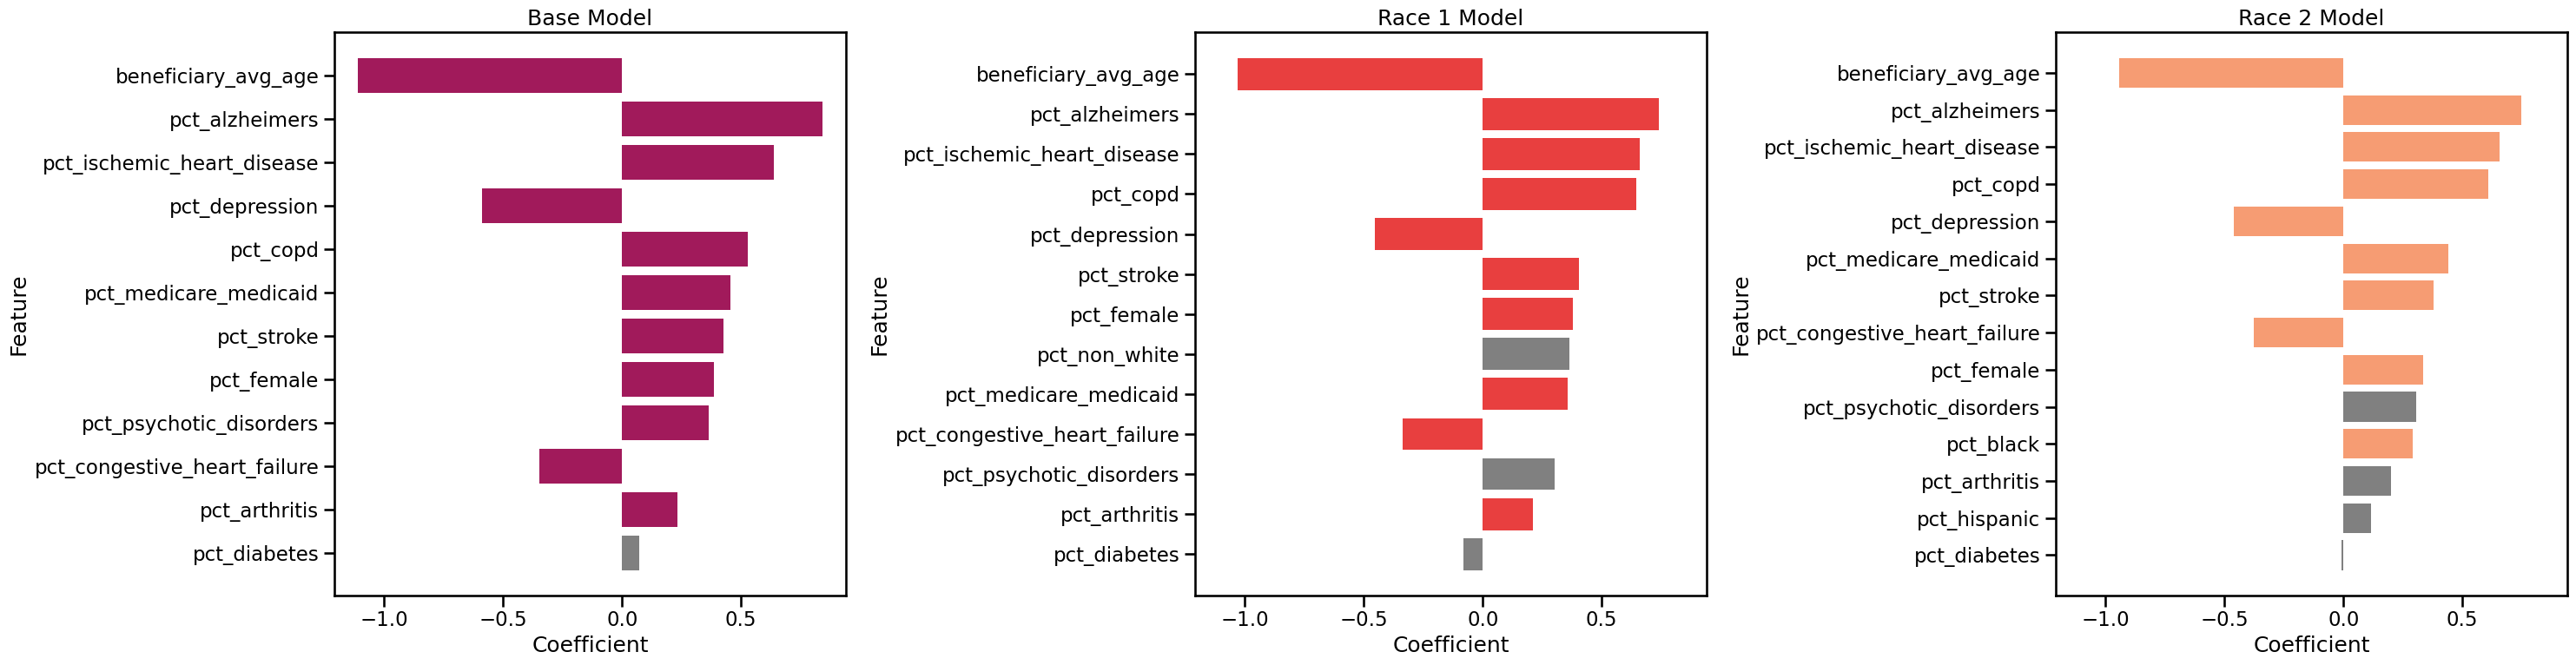

In [193]:
fig, ax = plt.subplots(1, 3, figsize=(30, 8), sharex=True)

plot_feature_weights_horizontal_sm(
    lm_base, ax=ax[0], color=lmpal[1], title="Base Model"
)
plot_feature_weights_horizontal_sm(
    lm_race_1, ax=ax[1], color=lmpal[2], title="Race 1 Model"
)
plot_feature_weights_horizontal_sm(
    lm_race_2, ax=ax[2], color=lmpal[3], title="Race 2 Model"
)


plt.tight_layout()


## Random Forest
### Hyperparams
- for each model, grid search for hyperparams (or just do one or two)

### Fit w/ CV
- run k_fold cross validation for 1, 2, base with same split for each fold
    - save out MSE, R^2 for each fold into a dataframe that also contains condition name, model type and model name

### Eval
- plot performance of each model (RMSE + R^2) for each fold

### Feature analysis
- run feature importance for each model (or just one race one?)

## Save out

- merge lm and hf dataframes into a hf_results_df. 